# Data Plotting

This notebook is intended to be used on logs created by RomRaider.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pathlib import Path
from pprint import pprint
from IPython.display import display
from scipy import stats
from scipy.stats import gaussian_kde

sns.set_palette('deep')
sns.set_context('notebook')

In [9]:
LOG_BASE_DIR = Path('logs/RomRaiders_Logs')

all_logs = list(LOG_BASE_DIR.iterdir())
pprint(all_logs)

[PosixPath('logs/RomRaiders_Logs/romraiderlog_cold_e10_2_20220501_140718.csv'),
 PosixPath('logs/RomRaiders_Logs/romraiderlog_warm_e10_20220510_230224.csv'),
 PosixPath('logs/RomRaiders_Logs/romraiderlog_cold_e10_20220501_182124.csv')]


Linear fit function: 0.022302552387945904 +  0.20566685205967428


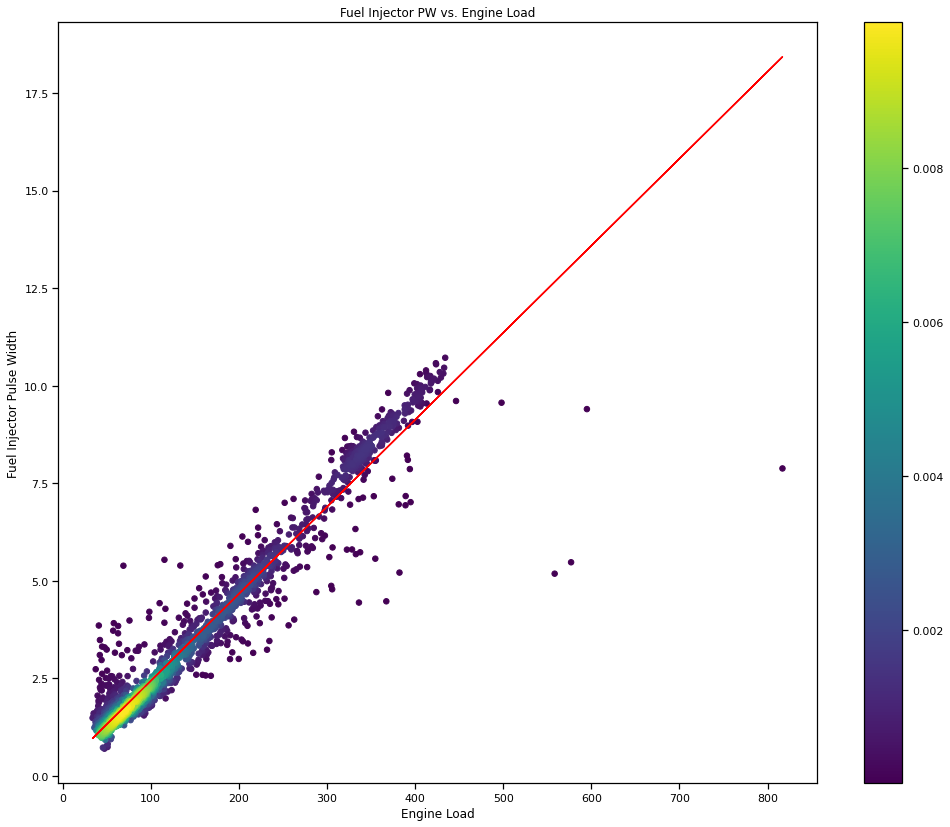

In [11]:
def plot_log(df):
    fig, ax = plt.subplots(figsize=(17,14))

    # Plot Engine Load versus Fuel Injector Pulse Width
    x = df['* Engine Load (mg/stroke)']
    y = df['* Fuel Injector Pulse Width (ms)']
    ax.set_xlabel('Engine Load')
    ax.set_ylabel('Fuel Injector Pulse Width')
    ax.set_title('Fuel Injector PW vs. Engine Load')

    # Get the fit
    res = stats.linregress(x, y)
    ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Plot the scatter plot
    cax = ax.scatter(x, y, c=z, s=30)
    
    # And add the legend for colors
    plt.colorbar(cax)
    

    print(f'Linear fit function: {res.slope} +  {res.intercept}')
    display(fig)
    plt.close(fig)
    return (res.slope, res.intercept)  # return the affine fit

    
log1 = Path('logs/RomRaiders_Logs/romraiderlog_warm_e10_20220510_230224.csv')
df1 = pd.read_csv(log2, encoding="iso-8859-1")
linear_func = plot_log(df2)

3427

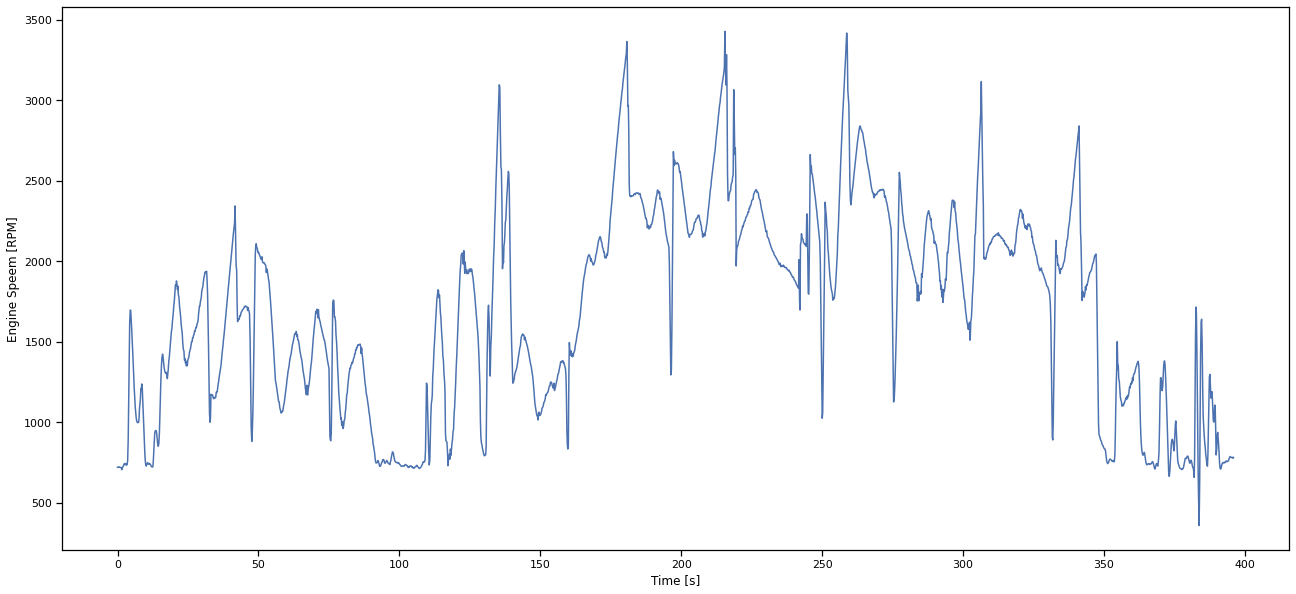

In [13]:
fig, ax = plt.subplots(figsize=(22,10))

ax.plot(df1['Time (msec)']/1000, df1['* Engine Speed (RPM)'])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Engine Speem [RPM]")
#ax.set_xlim(0, 280)
df1['* Engine Speed (RPM)'].max()

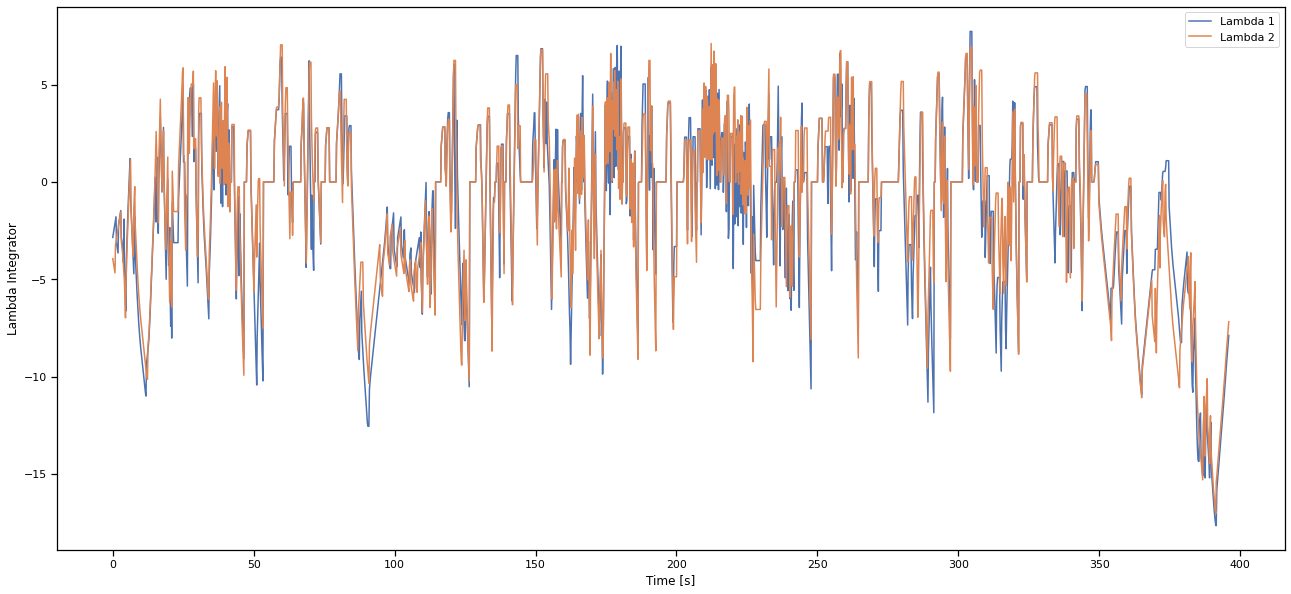

In [15]:
fig, ax = plt.subplots(figsize=(22,10))

df = df1

ax.plot(df['Time (msec)']/1000, df['* Lambda Integrator - Bank 1 (%)'], label="Lambda 1")
ax.plot(df['Time (msec)']/1000, df['* Lambda Integrator - Bank 2 (%)'], label="Lambda 2")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Lambda Integrator")
#ax.set_xlim(0, 280)
ax.legend()

In [16]:
def read_map(s):
    rows = s.split('\n')
    m = [r.split('\t') for r in rows]
    df = pd.DataFrame(m)
    
    # Get the table headers and indices
    y_axis = df.loc[:,0][2:].astype(float).round(1).values
    x_axis = df.loc[1][:-1].astype(float).round(0) # The values have useless decimals
    
    # and remove them from the values themselves
    df = df.loc[2:]
    df = df.loc[:,1:]
    
    # Set the headers and indices
    df.columns = x_axis
    df = df.set_index(y_axis)
        
    df = df.astype(float).round(4)  # round the table so it's less stupid with the precision
    return df


def apply_linear(fuel_map, function):
    slope = function[0]
    intercept = function[1]
    
    new_map = fuel_map.copy()
    for i in range(len(fuel_map.columns)):
        new_map.iloc[:,i] = (fuel_map.columns * slope + intercept)[i].round(3)

    return new_map
    

# Read the fuel map from RomRaider
fuel_map = read_map('''[Table3D]
33.000274017	49.998488379	70.00636164299999	99.996976758	130.008786654	199.993953516	249.99244189499998	299.990930274	349.989418653	419.99578029599996	500.006078571	600.003055329
400.0	0.78	1.1280000000000001	1.624	2.312	3.056	4.924	6.264	7.66	9.18	11.396	13.564	16.276
650.0	0.78	1.1280000000000001	1.54	2.22	2.904	4.616	5.88	7.252	8.74	10.552	12.56	15.072000000000001
900.0	0.78	1.112	1.54	2.24	2.86	4.468	5.74	7.0	8.34	10.32	12.428	14.912
1250.0	0.78	1.084	1.512	2.212	2.86	4.58	5.78	7.132000000000001	8.56	10.476	12.472	14.96
1500.0	0.78	1.112	1.52	2.232	2.9	4.62	5.84	7.1000000000000005	8.5	10.376	12.448	14.936
1750.0	0.78	1.1280000000000001	1.52	2.22	2.92	4.62	5.848	7.1000000000000005	8.392	10.428	12.464	14.956
2000.0	0.78	1.1400000000000001	1.52	2.22	2.94	4.62	5.8	7.04	8.32	10.128	12.32	14.64
3000.0	0.78	1.168	1.56	2.2600000000000002	2.96	4.572	5.74	6.988	8.292	10.116	12.204	14.452
3750.0	0.78	1.108	1.552	2.232	2.932	4.468	5.7	6.92	8.184000000000001	9.912	12.152000000000001	14.584
4000.0	0.78	1.096	1.576	2.2520000000000002	2.92	4.492	5.672	6.944	8.18	9.948	12.216000000000001	14.66
4250.0	0.78	1.092	1.552	2.24	2.872	4.46	5.66	6.928	8.152000000000001	9.856	12.120000000000001	14.544
4500.0	0.78	1.096	1.56	2.232	2.892	4.42	5.628	6.932	8.08	9.836	12.280000000000001	14.544
5000.0	0.78	1.092	1.592	2.2	2.86	4.42	5.672	6.88	8.06	9.944	12.172	14.464
5500.0	0.78	1.096	1.616	2.232	2.86	4.42	5.66	6.852	8.104000000000001	9.944	12.012	14.464
6000.0	0.78	1.12	1.568	2.24	2.88	4.5120000000000005	5.68	6.872	8.28	10.148	12.012	14.464
6500.0	0.78	1.08	1.512	2.36	2.904	4.5440000000000005	5.696	6.896	8.216	10.284	12.152000000000001	14.584''')

# Apply the Affine Function to it
new_fuel_map = apply_linear(fuel_map, linear_func)

    
display(fuel_map)
display(new_fuel_map)

1,33.0,50.0,70.0,100.0,130.0,200.0,250.0,300.0,350.0,420.0,500.0,600.0
400.0,0.78,1.128,1.624,2.312,3.056,4.924,6.264,7.660,9.180,11.396,13.564,16.276
650.0,0.78,1.128,1.540,2.220,2.904,4.616,5.880,7.252,8.740,10.552,12.560,15.072
900.0,0.78,1.112,1.540,2.240,2.860,4.468,5.740,7.000,8.340,10.320,12.428,14.912
1250.0,0.78,1.084,1.512,2.212,2.860,4.580,5.780,7.132,8.560,10.476,12.472,14.960
1500.0,0.78,1.112,1.520,2.232,2.900,4.620,5.840,7.100,8.500,10.376,12.448,14.936
1750.0,0.78,1.128,1.520,2.220,2.920,4.620,5.848,7.100,8.392,10.428,12.464,14.956
2000.0,0.78,1.140,1.520,2.220,2.940,4.620,5.800,7.040,8.320,10.128,12.320,14.640
3000.0,0.78,1.168,1.560,2.260,2.960,4.572,5.740,6.988,8.292,10.116,12.204,14.452
3750.0,0.78,1.108,1.552,2.232,2.932,4.468,5.700,6.920,8.184,9.912,12.152,14.584
4000.0,0.78,1.096,1.576,2.252,2.920,4.492,5.672,6.944,8.180,9.948,12.216,14.660


1,33.0,50.0,70.0,100.0,130.0,200.0,250.0,300.0,350.0,420.0,500.0,600.0
400.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
650.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
900.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
1250.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
1500.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
1750.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
2000.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
3000.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
3750.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
4000.0,0.942,1.321,1.767,2.436,3.105,4.666,5.781,6.896,8.012,9.573,11.357,13.587
